In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df_train = pd.read_csv('train.csv')
#df_test = pd.read_csv('test.csv')

In [4]:
df_train_nan = df_train.isnull()
count_all_train = len(df_train_nan.index) * len(df_train_nan.columns)
np.count_nonzero(df_train.isnull()) / count_all_train

0.08534357845498329

In [161]:
def preprocessing_1(df):
    import datetime
    # перевод дат из строк в даты 
    df['DTIME_CREDIT'] = pd.to_datetime( df['DTIME_CREDIT'], format="%d.%m.%Y" )
    df['DTIME_CREDIT_ENDDATE'] = pd.to_datetime( df['DTIME_CREDIT_ENDDATE'], format="%d.%m.%Y" )
    df['DTIME_CREDIT_ENDDATE_FACT'] = pd.to_datetime( df['DTIME_CREDIT_ENDDATE_FACT'], format="%d.%m.%Y" )
    df['DTIME_CREDIT_UPDATE'] = pd.to_datetime( df['DTIME_CREDIT_UPDATE'], format="%d.%m.%Y" )
    
    # удаляем выбросы дат
    df = df[df['DTIME_CREDIT_UPDATE'] < 
                                        datetime.datetime.strptime('01.01.2017','%d.%m.%Y') ]
    df = df[df['DTIME_CREDIT_UPDATE'] > 
                                        datetime.datetime.strptime('01.01.2000','%d.%m.%Y') ]
    
    # будем группировать по полям ['ID','SK_DATE_DECISION','DTIME_CREDIT','DTIME_CREDIT_ENDDATE',
    # 'AMT_CREDIT_SUM','CREDIT_CURRENCY']. Поэтому почистим от NaN эти поля
    df_fill_ed = df.copy()
    df_fill_ed.DTIME_CREDIT_ENDDATE[df_fill_ed.DTIME_CREDIT_ENDDATE.isnull()] = \
        df_fill_ed.DTIME_CREDIT_ENDDATE_FACT[df_fill_ed.DTIME_CREDIT_ENDDATE.isnull()]
    df_fill_ed.DTIME_CREDIT_ENDDATE.fillna(0, inplace=True)
    df_null = pd.isnull(df_fill_ed[['ID',
             'SK_DATE_DECISION',
             'DTIME_CREDIT',
             'DTIME_CREDIT_ENDDATE',
             'AMT_CREDIT_SUM',
             'CREDIT_CURRENCY']]).unstack()
    drop_indexes = [ a[1] for a in np.array(df_null[df_null].index) ]
    df_fill_ed = df_fill_ed.drop(df_fill_ed.index[drop_indexes])
    return df_fill_ed

In [181]:
def preprocessing_2(df):
# получим самую свежую дату обращения в какое-либо из бюро по каждому из кредитов
# и добавим полученные нами даты к основному набору
    sumtbl = df_fill_ed.pivot_table(['DTIME_CREDIT_UPDATE'],  
                                      ['ID',
                                         'SK_DATE_DECISION',
                                         'DTIME_CREDIT',
                                         'DTIME_CREDIT_ENDDATE',
                                         'CREDIT_CURRENCY'], aggfunc='max')
    df_fill_ed = df_fill_ed.merge(sumtbl, 'left', 
                                     left_on=['ID',
                                         'SK_DATE_DECISION',
                                         'DTIME_CREDIT',
                                         'DTIME_CREDIT_ENDDATE',
                                         'CREDIT_CURRENCY'], 
                                     right_index=True,
                                     suffixes=('', '_max'))
    df_fill_ed = df.copy()
    # преобразуем TEXT_PAYMENT_DISCIPLINE
    vals = list(range(6)) + ['C','X']
    PMTstr = pd.DataFrame([{'TEXT_PAYMENT_DISCIPLINE_%s' % (str(j)): str(i).count(str(j)) for j in vals} 
                           for i in df_fill_ed.TEXT_PAYMENT_DISCIPLINE])
    df_fill_ed = df_fill_ed.join(PMTstr).drop(['TEXT_PAYMENT_DISCIPLINE'], axis=1)
    
    # преобразуем CREDIT_TYPE
    vals = [0,1,2,3,4,5,6,7,8,9,10,18,19,99]
    PMTstr = pd.DataFrame([{'CREDIT_TYPE_%s' % (str(j)): str(i).count(str(j)) for j in vals} 
                           for i in df_fill_ed.CREDIT_TYPE])
    df_fill_ed = df_fill_ed.join(PMTstr).drop(['CREDIT_TYPE'], axis=1)
    
    # преобразуем CREDIT_ACTIVE
    vals = [0,1,2,3]
    PMTstr = pd.DataFrame([{'CREDIT_ACTIVE_%s' % (str(j)): str(i).count(str(j)) for j in vals} 
                           for i in df_fill_ed.CREDIT_ACTIVE])
    df_fill_ed = df_fill_ed.join(PMTstr).drop(['CREDIT_ACTIVE'], axis=1)
    
    # преобразуем NUM_SOURCE
    vals = [1,2,3,4]
    PMTstr = pd.DataFrame([{'NUM_SOURCE_%s' % (str(j)): str(i).count(str(j)) for j in vals} 
                           for i in df_fill_ed.NUM_SOURCE])
    df_fill_ed = df_fill_ed.join(PMTstr).drop(['NUM_SOURCE'], axis=1)
    
# преобразуем дату последнего платежа в бинарный признак: 0 - не было, 1 - был
    df_fill_ed.DTIME_CREDIT_ENDDATE_FACT[df_fill_ed.DTIME_CREDIT_ENDDATE_FACT.notnull()] = 1
    df_fill_ed.DTIME_CREDIT_ENDDATE_FACT.fillna(0, inplace=True)
    
    retDf = df_fill_ed[df_fill_ed.DTIME_CREDIT_UPDATE == 
                       df_fill_ed.DTIME_CREDIT_UPDATE_max].drop_duplicates()
# группируем по индексам, указанным выше
    retDf = retDf.groupby(['ID',
                         'DTIME_CREDIT',
                         'DTIME_CREDIT_ENDDATE',
                         'AMT_CREDIT_SUM',
                         'CREDIT_CURRENCY']).max().reset_index()
    
#   убираем колонки с датами( СИЛЬНОЕ ДОПУЩЕНИЕ )
    retDf = retDf.drop(['SK_DATE_DECISION',
                              'DTIME_CREDIT_UPDATE',
                              'DTIME_CREDIT',
                              'DTIME_CREDIT_ENDDATE',
                              'DTIME_CREDIT_ENDDATE_FACT'], axis=1)
#                               'DTIME_CREDIT_UPDATE_max'], axis=1)
    
    # сопоставляем с курсами валют
    curs = pd.DataFrame([ 57.59,67.69,58.45,1], index=['usd','eur','chf','rur'], columns=['crs'])
    retDf = retDf.merge(curs, 'left', left_on='CREDIT_CURRENCY', right_index=True)
    retDf.AMT_CREDIT_SUM = retDf.AMT_CREDIT_SUM * retDf.crs
    retDf.AMT_CREDIT_SUM_LIMIT = retDf.AMT_CREDIT_SUM_LIMIT * retDf.crs
    retDf.AMT_CREDIT_SUM_DEBT = retDf.AMT_CREDIT_SUM_DEBT * retDf.crs
    retDf.AMT_CREDIT_SUM_OVERDUE = retDf.AMT_CREDIT_SUM_OVERDUE * retDf.crs
    retDf.AMT_ANNUITY = retDf.AMT_ANNUITY * retDf.crs

    #выделяем значения в отдельные столбцы
    vals = ['usd','eur','chf','rur']
    PMTstr = pd.DataFrame([{'CREDIT_CURRENCY_%s' % (str(j)): str(i).count(str(j)) for j in vals} 
                           for i in retDf.CREDIT_CURRENCY])
    retDf = retDf.join(PMTstr).drop(['CREDIT_CURRENCY','crs'], axis=1)
    
    # добавляем фиктивное поле с количеством кредитов( для фич )
    retDf['count_credit'] = 1
    retDf.fillna(0, inplace=True)
    return retDf

In [179]:
Pre1DS = preprocessing_1(df_train)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [182]:
PreFinalDS = preprocessing_2(Pre1DS)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [184]:
# FinalDF = Pre1DS.copy()
# FinalDF.fillna(0, inplace=True)
# FinalDF = FinalDF.drop(['SK_DATE_DECISION',
#                               'DTIME_CREDIT_UPDATE',
#                               'DTIME_CREDIT',
#                               'DTIME_CREDIT_ENDDATE',
#                               'DTIME_CREDIT_ENDDATE_FACT'], axis=1)
FinalDF = PreFinalDS.groupby(['ID','DEF']).sum()
rename_dict = {}
for column in columns:
    rename_dict[column] = column + '_sum'
rename_dict.pop('ID', None)
rename_dict.pop('DEF', None)
FinalDF = FinalDF.rename(columns=rename_dict)

columns = list(PreFinalDS.columns)
addFinalDF = PreFinalDS.groupby(['ID','DEF']).mean()
rename_dict = {}
for column in columns:
    rename_dict[column] = column + '_mean'
rename_dict.pop('ID', None)
rename_dict.pop('DEF', None)
addFinalDF = addFinalDF.rename(columns=rename_dict)
FinalDF = FinalDF.join(addFinalDF)

columns = list(PreFinalDS.columns)
addFinalDF = PreFinalDS.groupby(['ID','DEF']).min()
rename_dict = {}
for column in columns:
    rename_dict[column] = column + '_min'
rename_dict.pop('ID', None)
rename_dict.pop('DEF', None)
addFinalDF = addFinalDF.rename(columns=rename_dict)
FinalDF = FinalDF.join(addFinalDF)

columns = list(PreFinalDS.columns)
addFinalDF = PreFinalDS.groupby(['ID','DEF']).max()
rename_dict = {}
for column in columns:
    rename_dict[column] = column + '_max'
rename_dict.pop('ID', None)
rename_dict.pop('DEF', None)
addFinalDF = addFinalDF.rename(columns=rename_dict)
FinalDF = FinalDF.join(addFinalDF)

columns = list(PreFinalDS.columns)
addFinalDF = PreFinalDS.groupby(['ID','DEF']).median()
rename_dict = {}
for column in columns:
    rename_dict[column] = column + '_median'
rename_dict.pop('ID', None)
rename_dict.pop('DEF', None)
addFinalDF = addFinalDF.rename(columns=rename_dict)
FinalDF = FinalDF.join(addFinalDF)

#print(FinalDF.columns)

FinalDF = FinalDF.reset_index(level=1)
FinalDF.head(5)

,DEF,CREDIT_COLLATERAL_sum,CREDIT_DAY_OVERDUE_sum,CREDIT_FACILITY_sum,AMT_CREDIT_MAX_OVERDUE_sum,CNT_CREDIT_PROLONG_sum,AMT_CREDIT_SUM_sum,AMT_CREDIT_SUM_DEBT_sum,AMT_CREDIT_SUM_LIMIT_sum,AMT_CREDIT_SUM_OVERDUE_sum,CREDIT_SUM_TYPE_sum,CREDIT_DELAY30_sum,CREDIT_DELAY5_sum,CREDIT_DELAY60_sum,CREDIT_DELAY90_sum,CREDIT_DELAY_MORE_sum,AMT_REQ_SOURCE_HOUR_sum,AMT_REQ_SOURCE_DAY_sum,AMT_REQ_SOURCE_WEEK_sum,AMT_REQ_SOURCE_MON_sum,AMT_REQ_SOURCE_QRT_sum,AMT_REQ_SOURCE_YEAR_sum,AMT_ANNUITY_sum,TEXT_PAYMENT_DISCIPLINE_0_sum,TEXT_PAYMENT_DISCIPLINE_1_sum,TEXT_PAYMENT_DISCIPLINE_2_sum,TEXT_PAYMENT_DISCIPLINE_3_sum,TEXT_PAYMENT_DISCIPLINE_4_sum,TEXT_PAYMENT_DISCIPLINE_5_sum,TEXT_PAYMENT_DISCIPLINE_C_sum,TEXT_PAYMENT_DISCIPLINE_X_sum,CREDIT_TYPE_0_sum,CREDIT_TYPE_1_sum,CREDIT_TYPE_10_sum,CREDIT_TYPE_18_sum,CREDIT_TYPE_19_sum,CREDIT_TYPE_2_sum,CREDIT_TYPE_3_sum,CREDIT_TYPE_4_sum,CREDIT_TYPE_5_sum,CREDIT_TYPE_6_sum,CREDIT_TYPE_7_sum,CREDIT_TYPE_8_sum,CREDIT_TYPE_9_sum,CREDIT_TYPE_99_sum,CREDIT_ACTIVE_0_sum,CREDIT_ACTIVE_1_sum,CREDIT_ACTIVE_2_sum,CREDIT_ACTIVE_3_sum,NUM_SOURCE_1_sum,NUM_SOURCE_2_sum,NUM_SOURCE_3_sum,NUM_SOURCE_4_sum,CREDIT_CURRENCY_chf_sum,CREDIT_CURRENCY_eur_sum,CREDIT_CURRENCY_rur_sum,CREDIT_CURRENCY_usd_sum,count_credit_sum,CREDIT_COLLATERAL_mean,CREDIT_DAY_OVERDUE_mean,CREDIT_FACILITY_mean,AMT_CREDIT_MAX_OVERDUE_mean,CNT_CREDIT_PROLONG_mean,AMT_CREDIT_SUM_mean,AMT_CREDIT_SUM_DEBT_mean,AMT_CREDIT_SUM_LIMIT_mean,AMT_CREDIT_SUM_OVERDUE_mean,CREDIT_SUM_TYPE_mean,CREDIT_DELAY30_mean,CREDIT_DELAY5_mean,CREDIT_DELAY60_mean,CREDIT_DELAY90_mean,CREDIT_DELAY_MORE_mean,AMT_REQ_SOURCE_HOUR_mean,AMT_REQ_SOURCE_DAY_mean,AMT_REQ_SOURCE_WEEK_mean,AMT_REQ_SOURCE_MON_mean,AMT_REQ_SOURCE_QRT_mean,AMT_REQ_SOURCE_YEAR_mean,AMT_ANNUITY_mean,TEXT_PAYMENT_DISCIPLINE_0_mean,TEXT_PAYMENT_DISCIPLINE_1_mean,TEXT_PAYMENT_DISCIPLINE_2_mean,TEXT_PAYMENT_DISCIPLINE_3_mean,TEXT_PAYMENT_DISCIPLINE_4_mean,TEXT_PAYMENT_DISCIPLINE_5_mean,TEXT_PAYMENT_DISCIPLINE_C_mean,TEXT_PAYMENT_DISCIPLINE_X_mean,CREDIT_TYPE_0_mean,CREDIT_TYPE_1_mean,CREDIT_TYPE_10_mean,CREDIT_TYPE_18_mean,CREDIT_TYPE_19_mean,CREDIT_TYPE_2_mean,CREDIT_TYPE_3_mean,CREDIT_TYPE_4_mean,CREDIT_TYPE_5_mean,CREDIT_TYPE_6_mean,CREDIT_TYPE_7_mean,CREDIT_TYPE_8_mean,CREDIT_TYPE_9_mean,CREDIT_TYPE_99_mean,CREDIT_ACTIVE_0_mean,CREDIT_ACTIVE_1_mean,CREDIT_ACTIVE_2_mean,CREDIT_ACTIVE_3_mean,NUM_SOURCE_1_mean,NUM_SOURCE_2_mean,NUM_SOURCE_3_mean,NUM_SOURCE_4_mean,CREDIT_CURRENCY_chf_mean,CREDIT_CURRENCY_eur_mean,CREDIT_CURRENCY_rur_mean,CREDIT_CURRENCY_usd_mean,count_credit_mean,CREDIT_COLLATERAL_min,CREDIT_DAY_OVERDUE_min,CREDIT_FACILITY_min,AMT_CREDIT_MAX_OVERDUE_min,CNT_CREDIT_PROLONG_min,AMT_CREDIT_SUM_min,AMT_CREDIT_SUM_DEBT_min,AMT_CREDIT_SUM_LIMIT_min,AMT_CREDIT_SUM_OVERDUE_min,CREDIT_SUM_TYPE_min,CREDIT_DELAY30_min,CREDIT_DELAY5_min,CREDIT_DELAY60_min,CREDIT_DELAY90_min,CREDIT_DELAY_MORE_min,AMT_REQ_SOURCE_HOUR_min,AMT_REQ_SOURCE_DAY_min,AMT_REQ_SOURCE_WEEK_min,AMT_REQ_SOURCE_MON_min,AMT_REQ_SOURCE_QRT_min,AMT_REQ_SOURCE_YEAR_min,AMT_ANNUITY_min,TEXT_PAYMENT_DISCIPLINE_0_min,TEXT_PAYMENT_DISCIPLINE_1_min,TEXT_PAYMENT_DISCIPLINE_2_min,TEXT_PAYMENT_DISCIPLINE_3_min,TEXT_PAYMENT_DISCIPLINE_4_min,TEXT_PAYMENT_DISCIPLINE_5_min,TEXT_PAYMENT_DISCIPLINE_C_min,TEXT_PAYMENT_DISCIPLINE_X_min,CREDIT_TYPE_0_min,CREDIT_TYPE_1_min,CREDIT_TYPE_10_min,CREDIT_TYPE_18_min,CREDIT_TYPE_19_min,CREDIT_TYPE_2_min,CREDIT_TYPE_3_min,CREDIT_TYPE_4_min,CREDIT_TYPE_5_min,CREDIT_TYPE_6_min,CREDIT_TYPE_7_min,CREDIT_TYPE_8_min,CREDIT_TYPE_9_min,CREDIT_TYPE_99_min,CREDIT_ACTIVE_0_min,CREDIT_ACTIVE_1_min,CREDIT_ACTIVE_2_min,CREDIT_ACTIVE_3_min,NUM_SOURCE_1_min,NUM_SOURCE_2_min,NUM_SOURCE_3_min,NUM_SOURCE_4_min,CREDIT_CURRENCY_chf_min,CREDIT_CURRENCY_eur_min,CREDIT_CURRENCY_rur_min,CREDIT_CURRENCY_usd_min,count_credit_min,CREDIT_COLLATERAL_max,CREDIT_DAY_OVERDUE_max,CREDIT_FACILITY_max,AMT_CREDIT_MAX_OVERDUE_max,CNT_CREDIT_PROLONG_max,AMT_CREDIT_SUM_max,AMT_CREDIT_SUM_DEBT_max,AMT_CREDIT_SUM_LIMIT_max,AMT_CREDIT_SUM_OVERDUE_max,CREDI

In [185]:
trainDF = FinalDF.copy()
#trainDF = trainDF.set_index('ID')

In [116]:
#ctrlDF = FinalDF_ctrl.copy()
CorrKoef = trainDF.corr()
FieldDrop = [i for i in CorrKoef if CorrKoef[i].isnull().drop_duplicates().values[0]]
FieldDrop

['CREDIT_TYPE_2']

In [117]:
CorField = []
for i in CorrKoef:
    for j in CorrKoef.index[CorrKoef[i] > 0.9]:
        if i != j and j not in CorField and i not in CorField:
            CorField.append(j)
            print("%s-->%s: r^2=%f" % (i,j, CorrKoef[i][CorrKoef.index==j].values[0]))

CREDIT_SUM_TYPE-->CREDIT_TYPE_5: r^2=0.916636
CREDIT_SUM_TYPE-->CREDIT_ACTIVE_0: r^2=0.909693
CREDIT_SUM_TYPE-->CREDIT_CURRENCY_rur: r^2=0.978591
CREDIT_SUM_TYPE-->count_credit: r^2=0.978842
CREDIT_TYPE_18-->CREDIT_TYPE_8: r^2=0.994981
CREDIT_TYPE_19-->CREDIT_TYPE_9: r^2=0.969537


In [186]:
FieldDrop =FieldDrop + CorField
newtr = trainDF#.drop(FieldDrop, axis=1)
#control = ctrlDF.drop(FieldDrop, axis=1)

In [187]:
target = newtr.DEF#.values
train = newtr.drop('DEF', axis=1)#.values

In [465]:
from sklearn.decomposition import PCA
coder = PCA(n_components=20)
train = coder.fit_transform(train)

In [188]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

models = []
models.append(RandomForestClassifier(n_estimators=200, max_depth=10, criterion='entropy'))
models.append(GradientBoostingClassifier(max_depth = 10))
models.append(AdaBoostClassifier(n_estimators=200))
#models.append(KNeighborsClassifier(n_neighbors=20))
#models.append(GaussianNB())
#models.append(LogisticRegression(penalty='l2', C=0.001))

In [189]:
from sklearn.cross_validation import train_test_split
TRNtrain, TRNtest, TARtrain, TARtest = train_test_split(train, target, test_size=0.3, random_state=0)

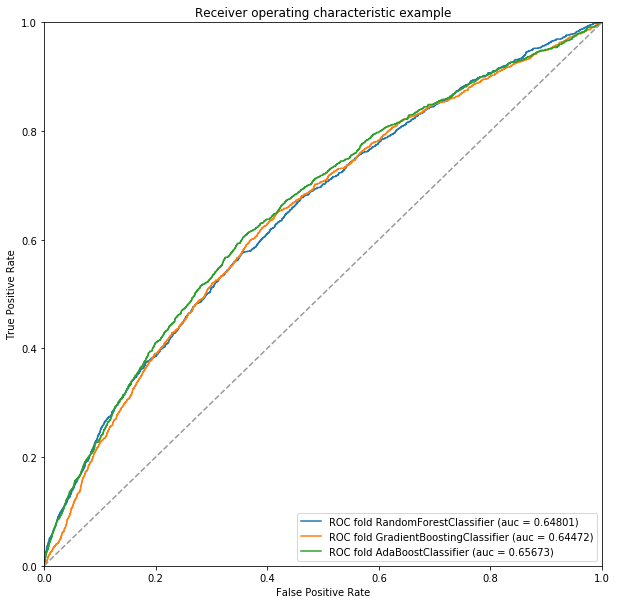

In [190]:
import ml_metrics
from sklearn.metrics import roc_curve
import matplotlib.pyplot as pl
from sklearn.feature_selection import RFE

plt.figure(figsize=(10, 10)) 
for model in models:
#    model.fit(train, target)
#    pred_scr = model.predict(control.values)
    model.fit(TRNtrain, TARtrain)
    pred_scr = model.predict_proba(TRNtest)[:, 1]
#     df_def = pd.DataFrame({'ID':TRNtest.ID, 'DEF':pred_scr})
#     df_def = df_def.groupby('ID').mean().sort_index()
#     TARtest_grp = TARtest.groupby('index').min().sort_index()
    fpr, tpr, thresholds = roc_curve(TARtest, pred_scr)
    roc_auc = ml_metrics.auc(TARtest.values, pred_scr)
    md = str(model)
    md = md[:md.find('(')]
    pl.plot(fpr, tpr, label='ROC fold %s (auc = %0.5f)' % (md, roc_auc))

pl.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
pl.xlim([0, 1])
pl.ylim([0, 1])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic example')
pl.legend(loc="lower right")
pl.show()

In [51]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
train.shape

(135155, 164)

In [431]:
df_def = pd.DataFrame({'DEF':pred})
df_def.index = control.index
df_def.groupby('DEF').count()
df_def.to_csv('third_ans.csv')

In [155]:
def azureml_main(dataframe1):
    SampleAccounts=dataframe1
    SampleAccounts.DTIME_CREDIT_ENDDATE[SampleAccounts.DTIME_CREDIT_ENDDATE.isnull()] = \
                        SampleAccounts.DTIME_CREDIT_ENDDATE_FACT[SampleAccounts.DTIME_CREDIT_ENDDATE.isnull()]
    SampleAccounts.DTIME_CREDIT_ENDDATE.fillna(0, inplace=True)
#переносим дату фактич закрытия в дату конца
    sumtbl = SampleAccounts.pivot_table(['DTIME_CREDIT_UPDATE'],  
                                        ['ID',
                                         'DTIME_CREDIT',
                                         'DTIME_CREDIT_ENDDATE',
                                         'AMT_CREDIT_SUM',
                                         'CREDIT_CURRENCY'], aggfunc='max')
#sumtbl - содержит уникальные ключи с максимумом по дате подтв
    SampleAccounts = SampleAccounts.merge(sumtbl, 'left', 
                                          left_on=['ID',
                                                 'DTIME_CREDIT',
                                                 'DTIME_CREDIT_ENDDATE',
                                                 'AMT_CREDIT_SUM',
                                                 'CREDIT_CURRENCY'], 
                                          right_index=True, suffixes=('', '_max'))
 #в конце добавили макс дату подтверждения
    SampleAccounts=SampleAccounts.drop_duplicates(['ID',
                                         'DTIME_CREDIT',
                                         'DTIME_CREDIT_ENDDATE',
                                         'AMT_CREDIT_SUM',
                                         'CREDIT_CURRENCY']).reset_index()
    df1=SampleAccounts.drop('index',axis=1)
#     curs = DataFrame([33.13,44.99,36.49,1], index=['USD','EUR','GHF','RUB'], columns=['crs'])
#     df2 = df1.merge(curs, 'left', left_on='currency', right_index=True)
#     df2.credit_limit = df2.credit_limit * df2.crs
    curs = pd.DataFrame([ 57.59,67.69,58.45,1], index=['usd','eur','chf','rur'], columns=['crs'])
    df2 = df1.merge(curs, 'left', left_on='CREDIT_CURRENCY', right_index=True)
    df2.AMT_CREDIT_SUM         = df2.AMT_CREDIT_SUM * df2.crs
    df2.AMT_CREDIT_SUM_LIMIT   = df2.AMT_CREDIT_SUM_LIMIT * df2.crs
    df2.AMT_CREDIT_SUM_DEBT    = df2.AMT_CREDIT_SUM_DEBT * df2.crs
    df2.AMT_CREDIT_SUM_OVERDUE = df2.AMT_CREDIT_SUM_OVERDUE * df2.crs
    df2.AMT_ANNUITY            = df2.AMT_ANNUITY * df2.crs
    
#записали в кредитный лимит сумму в рублях
    df2=df2.drop(['crs'], axis=1)
#выкинули курс
    df3 = df2[['ID','AMT_CREDIT_SUM','CREDIT_ACTIVE']]
    df3['act_lim']=df3.AMT_CREDIT_SUM[df3.CREDIT_ACTIVE==0]
    df3.act_lim.fillna(0, inplace=True)
    df4=df3.copy()
    df4['AMT_CREDIT_SUM'] = np.where(df3['CREDIT_ACTIVE']==0, 0, df3.CREDIT_ACTIVE)
    df5=df4.groupby(['ID']).sum()
    df5.rename(columns={'AMT_CREDIT_SUM':'AMT_CREDIT_SUM_CLOSED'}, inplace=True)
    df6=df5.drop('CREDIT_ACTIVE',axis=1)
    df6['otn_lim']=np.where(df6.AMT_CREDIT_SUM_CLOSED==0, 'A', df6.act_lim/df6.AMT_CREDIT_SUM_CLOSED)
    return df6

In [156]:
super_train = azureml_main(df_)

NameError: name 'df_train_fill_ed' is not defined

In [272]:
super_train.head(5)

,AMT_CREDIT_SUM_CLOSED,act_lim,otn_lim
ID,,,
24368,5,77949.0,15589.8
24369,5,95000.0,19000.0
24370,1,331200.0,331200.0
24372,1,339593.0,339593.0
24373,3,95875.0,31958.333333333332


In [433]:
FinalDF['AMT_CREDIT_SUM_CLOSED'] = super_train.AMT_CREDIT_SUM_CLOSED
FinalDF['act_lim'] = super_train.act_lim
FinalDF['otn_lim'] = super_train.otn_lim
FinalDF.head(5)

,DEF,AMT_CREDIT_SUM,CREDIT_COLLATERAL,CREDIT_DAY_OVERDUE,CREDIT_FACILITY,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_SUM_TYPE,CREDIT_DELAY30,CREDIT_DELAY5,CREDIT_DELAY60,CREDIT_DELAY90,CREDIT_DELAY_MORE,AMT_REQ_SOURCE_HOUR,AMT_REQ_SOURCE_DAY,AMT_REQ_SOURCE_WEEK,AMT_REQ_SOURCE_MON,AMT_REQ_SOURCE_QRT,AMT_REQ_SOURCE_YEAR,AMT_ANNUITY,TEXT_PAYMENT_DISCIPLINE_0,TEXT_PAYMENT_DISCIPLINE_1,TEXT_PAYMENT_DISCIPLINE_2,TEXT_PAYMENT_DISCIPLINE_3,TEXT_PAYMENT_DISCIPLINE_4,TEXT_PAYMENT_DISCIPLINE_5,TEXT_PAYMENT_DISCIPLINE_C,TEXT_PAYMENT_DISCIPLINE_X,CREDIT_TYPE_0,CREDIT_TYPE_1,CREDIT_TYPE_10,CREDIT_TYPE_18,CREDIT_TYPE_19,CREDIT_TYPE_2,CREDIT_TYPE_3,CREDIT_TYPE_4,CREDIT_TYPE_5,CREDIT_TYPE_6,CREDIT_TYPE_7,CREDIT_TYPE_8,CREDIT_TYPE_9,CREDIT_TYPE_99,CREDIT_ACTIVE_0,CREDIT_ACTIVE_1,CREDIT_ACTIVE_2,CREDIT_ACTIVE_3,NUM_SOURCE_1,NUM_SOURCE_2,NUM_SOURCE_3,NUM_SOURCE_4,CREDIT_CURRENCY_chf,CREDIT_CURRENCY_eur,CREDIT_CURRENCY_rur,CREDIT_CURRENCY_usd,count_credit,AMT_CREDIT_SUM_CLOSED,act_lim,otn_lim
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
24368,0,283821.0,0,0,0.0,0.0,0,97823.75,0.00,0.0,8,0,0,0,0,0,0,0,0,0,0,27,2324.0,71.0,0.0,0.0,0.0,0.0,0.0,86.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,1.0,0.0,1.0,0.0,7.0,3.0,0,0,9,0,9,5,77949.0,15589.8
24369,0,189130.0,0,120,0.0,0.0,0,65456.12,14543.88,11.0,6,0,0,0,0,0,0,0,0,0,0,35,706.0,19.0,0.0,0.0,0.0,0.0,1.0,39.0,353.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,1.0,0.0,1.0,4.0,1.0,1.0,0,0,7,0,7,5,95000.0,19000.0
24370,0,344290.0,0,0,0.0,0.0,0,2422.17,0.00,0.0,4,0,0,0,0,0,0,0,0,0,0,0,2510.0,37.0,0.0,0.0,0.0,0.0,0.0,216.0,41.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,2.0,2.0,2.0,0,0,5,0,5,1,331200.0,331200.0
24372,0,412993.0,0,0,0.0,1360.0,0,0.00,0.00,0.0,6,2,1,0,0,0,0,0,0,0,0,18,1993.0,90.0,1.0,0.0,0.0,0.0,0.0,305.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,5.0,0.0,1.0,1.0,0,0,6,0,6,1,339593.0,339593.0
24373,0,257875.0,0,0,0.0,0.0,0,41021.00,0.00,0.0,7,0,0,0,0,0,0,0,0,0,0,28,46001.0,38.0,0.0,0.0,0.0,0.0,0.0,79.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,7.0,0.0,0.0,0.0,0,0,7,0,7,3,95875.0,31958.333333333332


In [434]:
FinalDF.loc[FinalDF['otn_lim']=='A','otn_lim'] = -1

In [325]:
FinalDF[FinalDF['otn_lim']=='A'].head(5)

,DEF,AMT_CREDIT_SUM,CREDIT_COLLATERAL,CREDIT_DAY_OVERDUE,CREDIT_FACILITY,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_SUM_TYPE,CREDIT_DELAY30,CREDIT_DELAY5,CREDIT_DELAY60,CREDIT_DELAY90,CREDIT_DELAY_MORE,AMT_REQ_SOURCE_HOUR,AMT_REQ_SOURCE_DAY,AMT_REQ_SOURCE_WEEK,AMT_REQ_SOURCE_MON,AMT_REQ_SOURCE_QRT,AMT_REQ_SOURCE_YEAR,AMT_ANNUITY,TEXT_PAYMENT_DISCIPLINE_0,TEXT_PAYMENT_DISCIPLINE_1,TEXT_PAYMENT_DISCIPLINE_2,TEXT_PAYMENT_DISCIPLINE_3,TEXT_PAYMENT_DISCIPLINE_4,TEXT_PAYMENT_DISCIPLINE_5,TEXT_PAYMENT_DISCIPLINE_C,TEXT_PAYMENT_DISCIPLINE_X,CREDIT_TYPE_0,CREDIT_TYPE_1,CREDIT_TYPE_10,CREDIT_TYPE_18,CREDIT_TYPE_19,CREDIT_TYPE_2,CREDIT_TYPE_3,CREDIT_TYPE_4,CREDIT_TYPE_5,CREDIT_TYPE_6,CREDIT_TYPE_7,CREDIT_TYPE_8,CREDIT_TYPE_9,CREDIT_TYPE_99,CREDIT_ACTIVE_0,CREDIT_ACTIVE_1,CREDIT_ACTIVE_2,CREDIT_ACTIVE_3,NUM_SOURCE_1,NUM_SOURCE_2,NUM_SOURCE_3,NUM_SOURCE_4,CREDIT_CURRENCY_chf,CREDIT_CURRENCY_eur,CREDIT_CURRENCY_rur,CREDIT_CURRENCY_usd,count_credit,AMT_CREDIT_SUM_CLOSED,act_lim,otn_lim
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [336]:
df_test.head(5)

,ID,SK_DATE_DECISION,NUM_SOURCE,CREDIT_ACTIVE,CREDIT_COLLATERAL,CREDIT_CURRENCY,DTIME_CREDIT,CREDIT_DAY_OVERDUE,DTIME_CREDIT_ENDDATE,DTIME_CREDIT_ENDDATE_FACT,CREDIT_FACILITY,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_SUM_TYPE,CREDIT_TYPE,DTIME_CREDIT_UPDATE,CREDIT_DELAY30,CREDIT_DELAY5,CREDIT_DELAY60,CREDIT_DELAY90,CREDIT_DELAY_MORE,AMT_REQ_SOURCE_HOUR,AMT_REQ_SOURCE_DAY,AMT_REQ_SOURCE_WEEK,AMT_REQ_SOURCE_MON,AMT_REQ_SOURCE_QRT,AMT_REQ_SOURCE_YEAR,AMT_ANNUITY,TEXT_PAYMENT_DISCIPLINE
0,174640,20160301,1,0,0,rur,2007-07-06,0,2010-07-06,2010-07-06,NaN,NaN,0,54000.0,0.0,0.0,0.0,1,5,2010-11-02,0,0,1,0,0,0,0,0,0,0,6,0.0,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...
1,174640,20160301,3,0,0,rur,2007-07-06,0,2010-07-06,2010-07-06,NaN,NaN,0,54000.0,0.0,NaN,0.0,1,5,2010-07-31,1,0,0,0,0,0,0,0,0,0,6,0.0,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...
2,174640,20160301,4,0,0,rur,2007-07-06,0,2010-07-06,2010-07-06,NaN,1674.0,0,54000.0,NaN,NaN,0.0,1,5,2010-07-31,0,1,0,0,0,0,0,0,0,0,6,NaN,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...
3,174640,20160301,3,0,0,rur,2010-07-06,0,2011-01-11,2011-01-08,NaN,NaN,0,7578.0,0.0,NaN,0.0,1,5,2011-01-08,0,0,0,0,0,0,0,0,0,0,6,NaN,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...
4,174640,20160301,4,0,0,rur,2010-07-06,0,2011-01-11,2011-01-11,NaN,0.0,0,7578.0,0.0,0.0,0.0,0,5,2011-01-11,0,0,0,0,0,0,0,0,0,0,6,0.0,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...


In [432]:
pred = models[1].predict_proba(control.values)[:,1]
pred

array([ 0.02347043,  0.01939957,  0.02153869, ...,  0.03599991,
        0.0625001 ,  0.0863304 ])

In [464]:
FinalDF.head(5)

,DEF,AMT_CREDIT_SUM,CREDIT_COLLATERAL,CREDIT_DAY_OVERDUE,CREDIT_FACILITY,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_SUM_TYPE,CREDIT_DELAY30,CREDIT_DELAY5,CREDIT_DELAY60,CREDIT_DELAY90,CREDIT_DELAY_MORE,AMT_REQ_SOURCE_HOUR,AMT_REQ_SOURCE_DAY,AMT_REQ_SOURCE_WEEK,AMT_REQ_SOURCE_MON,AMT_REQ_SOURCE_QRT,AMT_REQ_SOURCE_YEAR,AMT_ANNUITY,TEXT_PAYMENT_DISCIPLINE_0,TEXT_PAYMENT_DISCIPLINE_1,TEXT_PAYMENT_DISCIPLINE_2,TEXT_PAYMENT_DISCIPLINE_3,TEXT_PAYMENT_DISCIPLINE_4,TEXT_PAYMENT_DISCIPLINE_5,TEXT_PAYMENT_DISCIPLINE_C,TEXT_PAYMENT_DISCIPLINE_X,CREDIT_TYPE_0,CREDIT_TYPE_1,CREDIT_TYPE_10,CREDIT_TYPE_18,CREDIT_TYPE_19,CREDIT_TYPE_2,CREDIT_TYPE_3,CREDIT_TYPE_4,CREDIT_TYPE_5,CREDIT_TYPE_6,CREDIT_TYPE_7,CREDIT_TYPE_8,CREDIT_TYPE_9,CREDIT_TYPE_99,CREDIT_ACTIVE_0,CREDIT_ACTIVE_1,CREDIT_ACTIVE_2,CREDIT_ACTIVE_3,NUM_SOURCE_1,NUM_SOURCE_2,NUM_SOURCE_3,NUM_SOURCE_4,CREDIT_CURRENCY_chf,CREDIT_CURRENCY_eur,CREDIT_CURRENCY_rur,CREDIT_CURRENCY_usd,count_credit
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
24368,0,283821.0,0,0,0.0,0.0,0,97823.75,0.00,0.0,8,0,0,0,0,0,0,0,0,0,0,27,2324.0,71.0,0.0,0.0,0.0,0.0,0.0,86.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,1.0,0.0,1.0,0.0,7.0,3.0,0,0,9,0,9
24369,0,189130.0,0,120,0.0,0.0,0,65456.12,14543.88,11.0,6,0,0,0,0,0,0,0,0,0,0,35,706.0,19.0,0.0,0.0,0.0,0.0,1.0,39.0,353.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,1.0,0.0,1.0,4.0,1.0,1.0,0,0,7,0,7
24370,0,344290.0,0,0,0.0,0.0,0,2422.17,0.00,0.0,4,0,0,0,0,0,0,0,0,0,0,0,2510.0,37.0,0.0,0.0,0.0,0.0,0.0,216.0,41.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,2.0,2.0,2.0,0,0,5,0,5
24372,0,412993.0,0,0,0.0,1360.0,0,0.00,0.00,0.0,6,2,1,0,0,0,0,0,0,0,0,18,1993.0,90.0,1.0,0.0,0.0,0.0,0.0,305.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,5.0,0.0,1.0,1.0,0,0,6,0,6
24373,0,257875.0,0,0,0.0,0.0,0,41021.00,0.00,0.0,7,0,0,0,0,0,0,0,0,0,0,28,46001.0,38.0,0.0,0.0,0.0,0.0,0.0,79.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,7.0,0.0,0.0,0.0,0,0,7,0,7


In [406]:
FinalDF.head(5)

,DEF,AMT_CREDIT_SUM,CREDIT_COLLATERAL,CREDIT_DAY_OVERDUE,CREDIT_FACILITY,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_SUM_TYPE,CREDIT_DELAY30,CREDIT_DELAY5,CREDIT_DELAY60,CREDIT_DELAY90,CREDIT_DELAY_MORE,AMT_REQ_SOURCE_HOUR,AMT_REQ_SOURCE_DAY,AMT_REQ_SOURCE_WEEK,AMT_REQ_SOURCE_MON,AMT_REQ_SOURCE_QRT,AMT_REQ_SOURCE_YEAR,AMT_ANNUITY,TEXT_PAYMENT_DISCIPLINE_0,TEXT_PAYMENT_DISCIPLINE_1,TEXT_PAYMENT_DISCIPLINE_2,TEXT_PAYMENT_DISCIPLINE_3,TEXT_PAYMENT_DISCIPLINE_4,TEXT_PAYMENT_DISCIPLINE_5,TEXT_PAYMENT_DISCIPLINE_C,TEXT_PAYMENT_DISCIPLINE_X,CREDIT_TYPE_0,CREDIT_TYPE_1,CREDIT_TYPE_10,CREDIT_TYPE_18,CREDIT_TYPE_19,CREDIT_TYPE_2,CREDIT_TYPE_3,CREDIT_TYPE_4,CREDIT_TYPE_5,CREDIT_TYPE_6,CREDIT_TYPE_7,CREDIT_TYPE_8,CREDIT_TYPE_9,CREDIT_TYPE_99,CREDIT_ACTIVE_0,CREDIT_ACTIVE_1,CREDIT_ACTIVE_2,CREDIT_ACTIVE_3,NUM_SOURCE_1,NUM_SOURCE_2,NUM_SOURCE_3,NUM_SOURCE_4,CREDIT_CURRENCY_chf,CREDIT_CURRENCY_eur,CREDIT_CURRENCY_rur,CREDIT_CURRENCY_usd,count_credit
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
24368,0,283821.0,0,0,0.0,0.0,0,97823.75,0.00,0.0,8,0,0,0,0,0,0,0,0,0,0,27,2324.0,71.0,0.0,0.0,0.0,0.0,0.0,86.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,1.0,0.0,1.0,0.0,7.0,3.0,0,0,9,0,9
24369,0,189130.0,0,120,0.0,0.0,0,65456.12,14543.88,11.0,6,0,0,0,0,0,0,0,0,0,0,35,706.0,19.0,0.0,0.0,0.0,0.0,1.0,39.0,353.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,1.0,0.0,1.0,4.0,1.0,1.0,0,0,7,0,7
24370,0,344290.0,0,0,0.0,0.0,0,2422.17,0.00,0.0,4,0,0,0,0,0,0,0,0,0,0,0,2510.0,37.0,0.0,0.0,0.0,0.0,0.0,216.0,41.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,2.0,2.0,2.0,0,0,5,0,5
24372,0,412993.0,0,0,0.0,1360.0,0,0.00,0.00,0.0,6,2,1,0,0,0,0,0,0,0,0,18,1993.0,90.0,1.0,0.0,0.0,0.0,0.0,305.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,5.0,0.0,1.0,1.0,0,0,6,0,6
24373,0,257875.0,0,0,0.0,0.0,0,41021.00,0.00,0.0,7,0,0,0,0,0,0,0,0,0,0,28,46001.0,38.0,0.0,0.0,0.0,0.0,0.0,79.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,7.0,0.0,0.0,0.0,0,0,7,0,7


In [411]:
target = target.astype(float)

In [425]:
models[0]

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=165, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [201]:
from sklearn.grid_search import RandomizedSearchCV
#, TRNtest, TARtrain, TARtest
adaHyperParams = {'n_estimators': [10,50,100,200,400]}
gridSearchAda = RandomizedSearchCV(estimator=AdaBoostClassifier(base_estimator=None, n_estimators=200, learning_rate=1.0), 
                                   param_distributions=adaHyperParams, n_iter=5,
                                   scoring='roc_auc', fit_params=None, cv=None, verbose=2).fit(TRNtrain, TARtrain)
gridSearchAda.best_params_, gridSearchAda.best_score_

C:\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] n_estimators=10 .................................................
[CV] ........................................ n_estimators=10 -   7.9s
[CV] n_estimators=10 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.0s remaining:    0.0s


[CV] ........................................ n_estimators=10 -   8.0s
[CV] n_estimators=10 .................................................
[CV] ........................................ n_estimators=10 -   7.7s
[CV] n_estimators=50 .................................................
[CV] ........................................ n_estimators=50 -  25.4s
[CV] n_estimators=50 .................................................
[CV] ........................................ n_estimators=50 -  16.4s
[CV] n_estimators=50 .................................................
[CV] ........................................ n_estimators=50 -  16.3s
[CV] n_estimators=100 ................................................
[CV] ....................................... n_estimators=100 -  52.1s
[CV] n_estimators=100 ................................................
[CV] ....................................... n_estimators=100 -  43.9s
[CV] n_estimators=100 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 25.1min finished


({'n_estimators': 50}, 0.6489232079527494)

In [ ]:
from scipy.stats import randint
gbMod = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=200, subsample=1.0,
                                   min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3,
                                   init=None, random_state=None, max_features=None, verbose=0)
gbHyperParams = {'loss' : ['deviance', 'exponential'],
                 'n_estimators': randint(10, 500),
                 'max_depth': randint(1,10)}
gridSearchGB = RandomizedSearchCV(estimator=gbMod, param_distributions=gbHyperParams, n_iter=10,
                                   scoring='roc_auc', fit_params=None, cv=None, verbose=2).fit(TRNtrain, TARtrain)
gridSearchGB.best_params_, gridSearchGB.best_score_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] loss=deviance, max_depth=3, n_estimators=76 .....................
[CV] ............ loss=deviance, max_depth=3, n_estimators=76 - 1.2min
[CV] loss=deviance, max_depth=3, n_estimators=76 .....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[CV] ............ loss=deviance, max_depth=3, n_estimators=76 - 1.5min
[CV] loss=deviance, max_depth=3, n_estimators=76 .....................
[CV] ............ loss=deviance, max_depth=3, n_estimators=76 - 1.6min
[CV] loss=deviance, max_depth=6, n_estimators=316 ....................
[CV] ........... loss=deviance, max_depth=6, n_estimators=316 -13.0min
[CV] loss=deviance, max_depth=6, n_estimators=316 ....................
[CV] ........... loss=deviance, max_depth=6, n_estimators=316 - 8.1min
[CV] loss=deviance, max_depth=6, n_estimators=316 ....................
[CV] ........... loss=deviance, max_depth=6, n_estimators=316 - 8.7min
[CV] loss=deviance, max_depth=6, n_estimators=89 .....................
[CV] ............ loss=deviance, max_depth=6, n_estimators=89 - 2.2min
[CV] loss=deviance, max_depth=6, n_estimators=89 .....................
[CV] ............ loss=deviance, max_depth=6, n_estimators=89 - 3.0min
[CV] loss=deviance, max_depth=6, n_estimators=89 .....................
[CV] .

In [205]:
def plotCvRocCurve(X, y, classifier, nfolds=5):
    
    from sklearn.metrics import roc_curve, auc
    from sklearn.cross_validation import StratifiedKFold
    import matplotlib.pyplot as plt
    from scipy import interp

    cv = StratifiedKFold(y, n_folds=nfolds)

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    for i, (train, test) in enumerate(cv):
        probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])

        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('CV ROC curve')
    plt.legend(loc="lower right")
    fig = plt.gcf()
    fig.set_size_inches(15,5)

    plt.show()

def rocZeroOne(y_true, y_predicted_porba):
    
    from sklearn.metrics import roc_curve
    from scipy.spatial.distance import euclidean
    
    fpr, tpr, thresholds = roc_curve(y_true, y_predicted_porba[:, 1])
    
    best = [0, 1]
    dist = []
    for (x, y) in zip(fpr, tpr):
        dist.append([euclidean([x,y], best)])

    bestPoint = [fpr[dist.index(min(dist))], tpr[dist.index(min(dist))]]
    
    bestCutOff1 = thresholds[list(fpr).index(bestPoint[0])]
    bestCutOff2 = thresholds[list(tpr).index(bestPoint[1])]
    
    print('\n' + 'Best point on the ROC: TPR = {:0.3f}%, FPR = {:0.3f}%'.format(bestPoint[1]*100, bestPoint[0]*100))
    print('\n' + 'Best Cut-Off point: {:0.4f}'.format(bestCutOff1))

    plt.plot(dist)
    plt.xlabel('Index')
    plt.ylabel('Euclidean Distance to the perfect [0,1]')
    fig = plt.gcf()
    fig.set_size_inches(15,5)

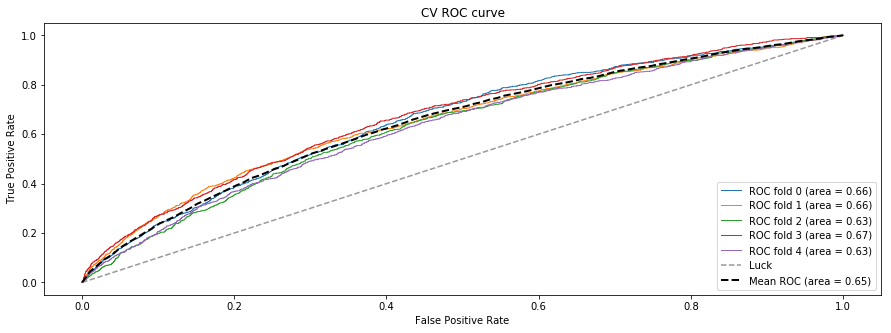

In [206]:
plotCvRocCurve(train, target, gridSearchAda.best_estimator_)

In [112]:
len(TRNtest.index.unique())

110052

In [146]:
TRNtest.ID += 100000
TRNtest.head(5)

C:\Anaconda3\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,ID,AMT_CREDIT_SUM,CREDIT_COLLATERAL,CREDIT_DAY_OVERDUE,CREDIT_FACILITY,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_SUM_TYPE,CREDIT_DELAY30,CREDIT_DELAY5,CREDIT_DELAY60,CREDIT_DELAY90,CREDIT_DELAY_MORE,AMT_REQ_SOURCE_HOUR,AMT_REQ_SOURCE_DAY,AMT_REQ_SOURCE_WEEK,AMT_REQ_SOURCE_MON,AMT_REQ_SOURCE_QRT,AMT_REQ_SOURCE_YEAR,AMT_ANNUITY,TEXT_PAYMENT_DISCIPLINE_0,TEXT_PAYMENT_DISCIPLINE_1,TEXT_PAYMENT_DISCIPLINE_2,TEXT_PAYMENT_DISCIPLINE_3,TEXT_PAYMENT_DISCIPLINE_4,TEXT_PAYMENT_DISCIPLINE_5,TEXT_PAYMENT_DISCIPLINE_C,TEXT_PAYMENT_DISCIPLINE_X,CREDIT_TYPE_0,CREDIT_TYPE_1,CREDIT_TYPE_10,CREDIT_TYPE_18,CREDIT_TYPE_19,CREDIT_TYPE_2,CREDIT_TYPE_3,CREDIT_TYPE_4,CREDIT_TYPE_5,CREDIT_TYPE_6,CREDIT_TYPE_7,CREDIT_TYPE_8,CREDIT_TYPE_9,CREDIT_TYPE_99,CREDIT_ACTIVE_0,CREDIT_ACTIVE_1,CREDIT_ACTIVE_2,CREDIT_ACTIVE_3,NUM_SOURCE_1,NUM_SOURCE_2,NUM_SOURCE_3,NUM_SOURCE_4,CREDIT_CURRENCY_chf,CREDIT_CURRENCY_eur,CREDIT_CURRENCY_rur,CREDIT_CURRENCY_usd,count_credit
908564,251323,60000.0,0,0,0.0,0.0,0,33463.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,5,0.0,10.0,0.0,0.0,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,1,0,1
972678,260654,44500.0,0,0,0.0,0.0,0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,2,0.0,4.0,1.0,0.0,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,1,0,1
869603,245946,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,3,0.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,1,0,1
690375,221389,60000.0,0,0,0.0,0.0,0,60613.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,2,0.0,3.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,1,0,1
63014,134058,89326.0,0,0,0.0,0.0,0,0.0,0.0,0.0,1,1,0,0,0,0,0,0,0,0,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,1,0,1


In [199]:
import datetime
pd.any(df_train.groupby('ID')['DTIME_CREDIT'].max() < datetime.datetime.strptime('01.01.2010','%d.%m.%Y'))

ID
24368     False
24369     False
24370     False
24372     False
24373     False
24374     False
24375     False
24376     False
24377     False
24378     False
24379     False
24380     False
24381      True
24382     False
24383     False
24384     False
24385     False
24386     False
24387     False
24388     False
24389     False
24390     False
24391     False
24392     False
24393     False
24394     False
24395     False
24396     False
24397     False
24398     False
          ...  
174604    False
174605    False
174606    False
174607    False
174608    False
174610    False
174612    False
174613    False
174614    False
174615    False
174616    False
174617    False
174618    False
174620    False
174622    False
174623    False
174624    False
174625    False
174626    False
174627    False
174628    False
174629    False
174630    False
174631    False
174632    False
174633    False
174635    False
174636    False
174638    False
175099    False
Name: DTIME_CREDIT, L

In [202]:
type(gridSearchAda)

sklearn.grid_search.RandomizedSearchCV